## Telemedicina - Adesão e impacto

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

In [2]:
# 1. CARREGAMENTO E LIMPEZA
# ---------------------------------------------------------
file_path = 'TMEDTREND_PUBLIC_250827.csv'
df = pd.read_csv(file_path)

                           Year  Total_Bene_TH_Elig  Total_PartB_Enrl  \
Year                   1.000000           -0.018868         -0.031665   
Total_Bene_TH_Elig    -0.018868            1.000000          0.997744   
Total_PartB_Enrl      -0.031665            0.997744          1.000000   
Total_Bene_Telehealth -0.136552            0.848184          0.866511   
Pct_Telehealth        -0.421883           -0.028347         -0.013210   

                       Total_Bene_Telehealth  Pct_Telehealth  
Year                               -0.136552       -0.421883  
Total_Bene_TH_Elig                  0.848184       -0.028347  
Total_PartB_Enrl                    0.866511       -0.013210  
Total_Bene_Telehealth               1.000000        0.246074  
Pct_Telehealth                      0.246074        1.000000  


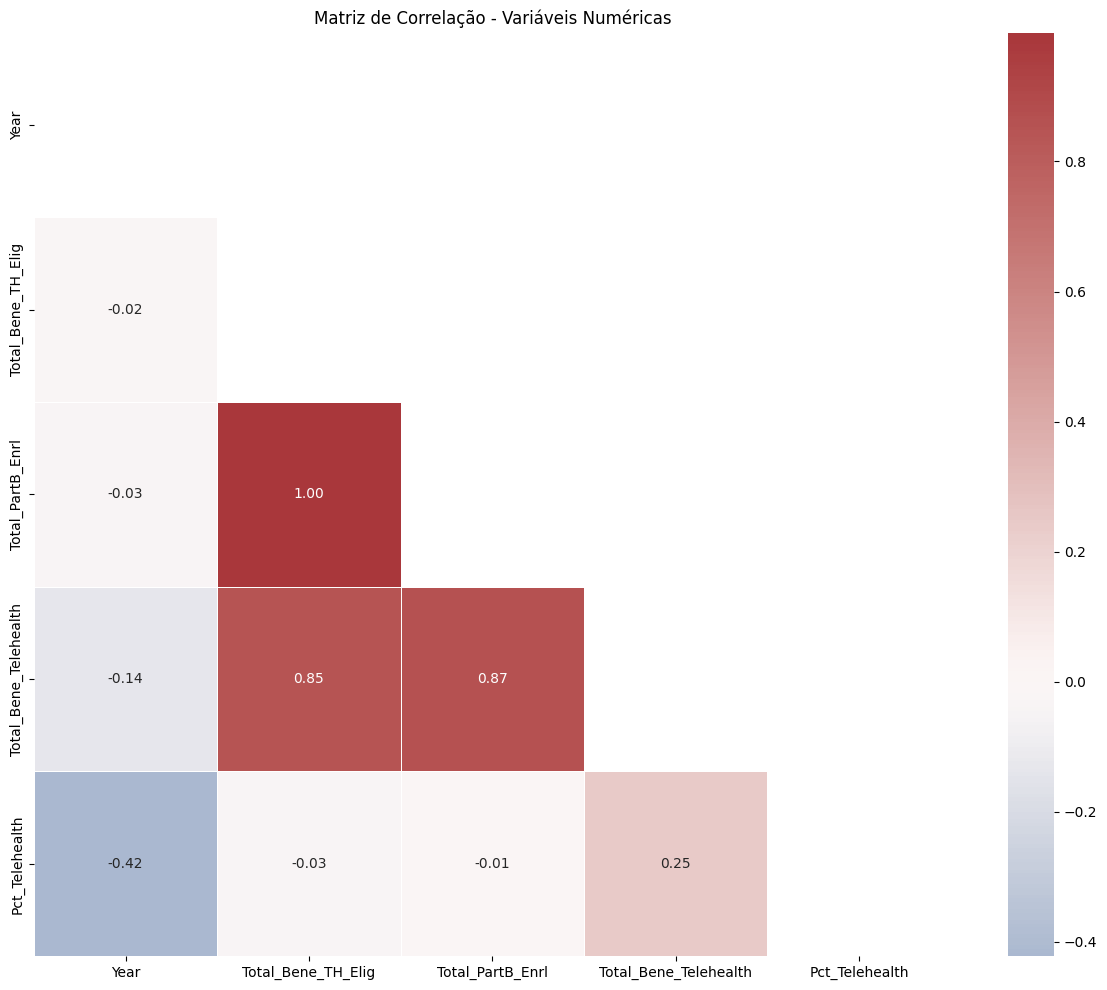

In [6]:
# 3. MATRIZ DE CORRELAÇÃO (usar df_clean definido abaixo)
# ---------------------------------------------------------
# Selecionar apenas colunas numéricas (já temos np importado)
numeric_df = df_clean.select_dtypes(include=[np.number]).copy()

# Remover colunas constantes ou todas NaN para evitar problemas na matriz
numeric_df = numeric_df.loc[:, numeric_df.nunique(dropna=True) > 1].dropna(axis=1, how='all')

# Calcular correlação
corr_matrix = numeric_df.corr()

# Exibir as primeiras linhas da matriz (opcional)
print(corr_matrix.head())

# Plotar heatmap com máscara para triângulo superior
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='vlag', center=0, linewidths=0.5)
plt.title('Matriz de Correlação - Variáveis Numéricas')
plt.tight_layout()
plt.show()

In [8]:
# Filtrar para remover agregações nacionais e anuais para focar na variação granular
# Mantemos apenas dados de níveis estaduais e trimestrais específicos
df_clean = df[
    (df['Bene_Geo_Desc'] != 'National') & 
    (df['quarter'] != 'Overall') &
    (df['Pct_Telehealth'].notna()) # Remove linhas sem a variável alvo
].copy()

In [9]:
# Converter colunas numéricas que podem ter sido lidas como texto
cols_to_numeric = ['Total_Bene_TH_Elig', 'Total_PartB_Enrl', 'Total_Bene_Telehealth', 'Pct_Telehealth']
for col in cols_to_numeric:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
    
df_clean.dropna(subset=['Pct_Telehealth'], inplace=True)

In [10]:
# 2. DEFINIÇÃO DO ALVO (TARGET)
# ---------------------------------------------------------
# Definir o limiar de "Alta Adoção" (Top 25%)
threshold = df_clean['Pct_Telehealth'].quantile(0.75)
df_clean['High_Adoption'] = (df_clean['Pct_Telehealth'] > threshold).astype(int)

In [11]:
print(f"Limiar de Alta Adoção (> 75%): {threshold:.4f}")
print(f"Distribuição das Classes:\n{df_clean['High_Adoption'].value_counts(normalize=True)}")

Limiar de Alta Adoção (> 75%): 0.2302
Distribuição das Classes:
High_Adoption
0    0.750111
1    0.249889
Name: proportion, dtype: float64


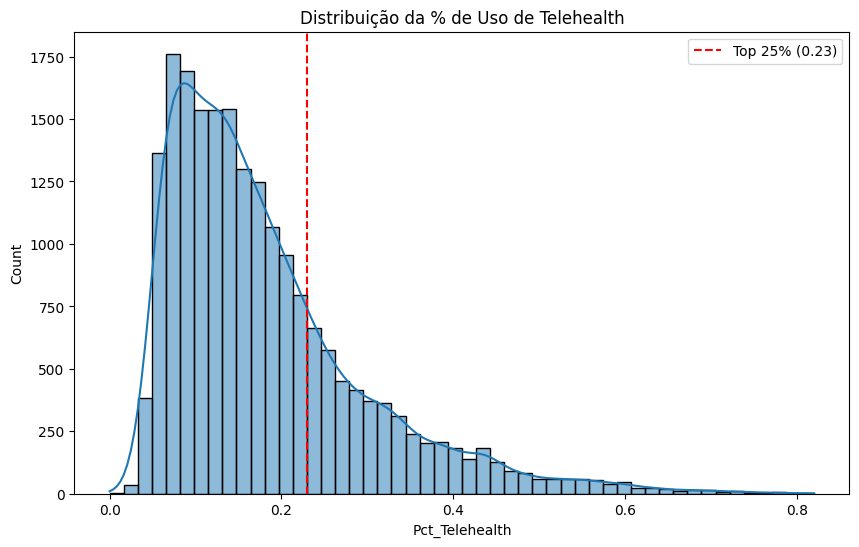

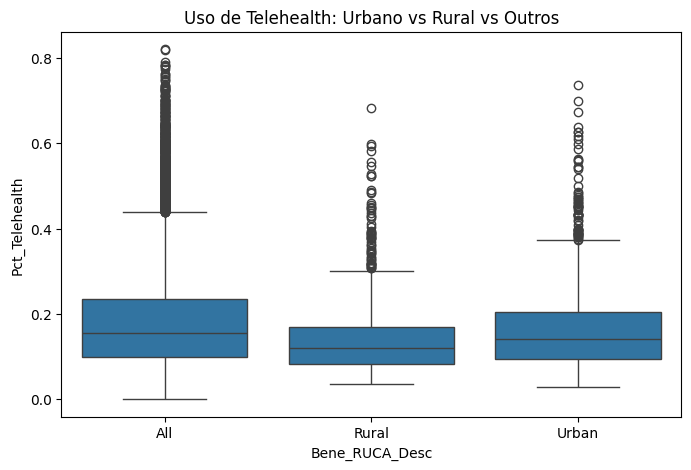

In [12]:
# 3. ANÁLISE EXPLORATÓRIA (EDA)
# ---------------------------------------------------------
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['Pct_Telehealth'], bins=50, kde=True)
plt.axvline(threshold, color='r', linestyle='--', label=f'Top 25% ({threshold:.2f})')
plt.title('Distribuição da % de Uso de Telehealth')
plt.legend()
plt.show()

# Boxplot para ver impacto Rural vs Urbano
plt.figure(figsize=(8, 5))
sns.boxplot(x='Bene_RUCA_Desc', y='Pct_Telehealth', data=df_clean)
plt.title('Uso de Telehealth: Urbano vs Rural vs Outros')
plt.show()

In [13]:
# 4. PREPARAÇÃO PARA MACHINE LEARNING
# ---------------------------------------------------------
# Selecionar features relevantes (Categoricas e Numéricas)
features_cat = ['Bene_Geo_Desc', 'Bene_Mdcd_Mdcr_Enrl_Stus', 'Bene_Race_Desc', 
                'Bene_Sex_Desc', 'Bene_Age_Desc', 'Bene_RUCA_Desc']
# Nota: Removemos 'Year' e 'quarter' para focar em características demográficas, 
# mas poderiam ser incluídos se o objetivo fosse previsão temporal.

# Codificação de Variáveis Categóricas (One-Hot Encoding)
X = pd.get_dummies(df_clean[features_cat], drop_first=True)
y = df_clean['High_Adoption']

# Divisão Treino/Teste (70% Treino, 30% Teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


--- Relatório de Classificação ---
              precision    recall  f1-score   support

           0       0.81      0.95      0.88      4552
           1       0.72      0.35      0.47      1545

    accuracy                           0.80      6097
   macro avg       0.77      0.65      0.67      6097
weighted avg       0.79      0.80      0.77      6097


--- Matriz de Confusão ---


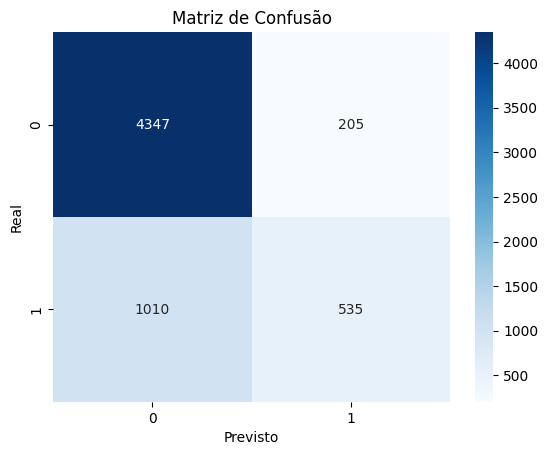

In [14]:
# 5. TREINAMENTO DO MODELO
# ---------------------------------------------------------
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

# Previsões
y_pred = clf.predict(X_test)

# 6. AVALIAÇÃO DE DESEMPENHO
# ---------------------------------------------------------
print("\n--- Relatório de Classificação ---")
print(classification_report(y_test, y_pred))

print("\n--- Matriz de Confusão ---")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.ylabel('Real')
plt.xlabel('Previsto')
plt.show()

In [16]:
# 7. IMPORTÂNCIA DAS VARIÁVEIS (Quais fatores mais influenciam?)
# ---------------------------------------------------------
feature_importances = pd.DataFrame(clf.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
print("\n--- Top 10 Fatores Mais Importantes ---")
print(feature_importances.head(10))


--- Top 10 Fatores Mais Importantes ---
                                              importance
Bene_Geo_Desc_California                        0.142712
Bene_Age_Desc_All                               0.059182
Bene_Geo_Desc_Hawaii                            0.048143
Bene_Age_Desc_85 and over                       0.045302
Bene_Geo_Desc_Massachusetts                     0.041794
Bene_Age_Desc_75-84                             0.039814
Bene_Age_Desc_65-74                             0.037323
Bene_Mdcd_Mdcr_Enrl_Stus_Medicare & Medicaid    0.035667
Bene_Race_Desc_American Indian/Alaska Native    0.021417
Bene_Geo_Desc_District Of Columbia              0.019647



--- Top 15 Fatores Mais Importantes ---
                                              importance
Bene_Geo_Desc_California                        0.142712
Bene_Age_Desc_All                               0.059182
Bene_Geo_Desc_Hawaii                            0.048143
Bene_Age_Desc_85 and over                       0.045302
Bene_Geo_Desc_Massachusetts                     0.041794
Bene_Age_Desc_75-84                             0.039814
Bene_Age_Desc_65-74                             0.037323
Bene_Mdcd_Mdcr_Enrl_Stus_Medicare & Medicaid    0.035667
Bene_Race_Desc_American Indian/Alaska Native    0.021417
Bene_Geo_Desc_District Of Columbia              0.019647
Bene_RUCA_Desc_Rural                            0.019301
Bene_Mdcd_Mdcr_Enrl_Stus_Medicare Only          0.018965
Bene_Sex_Desc_Male                              0.018289
Bene_Race_Desc_Black/African American           0.018183
Bene_Geo_Desc_Minnesota                         0.017659


C:\Users\vinir\AppData\Local\Temp\ipykernel_16732\249332511.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=top_15, palette='viridis')


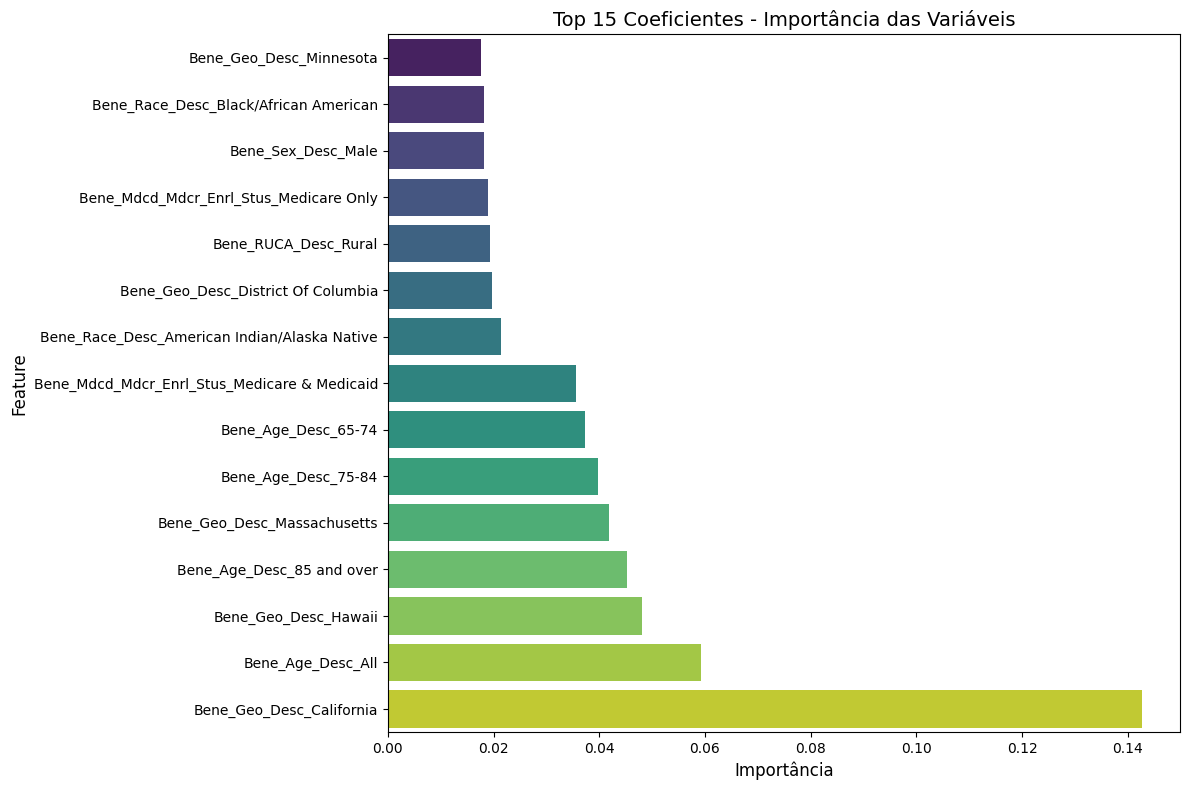

In [18]:
# 7. IMPORTÂNCIA DAS VARIÁVEIS - TOP 15 COEFICIENTES
# ---------------------------------------------------------
feature_importances = pd.DataFrame(
    clf.feature_importances_, 
    index=X_train.columns, 
    columns=['importance']
).sort_values('importance', ascending=False)

print("\n--- Top 15 Fatores Mais Importantes ---")
print(feature_importances.head(15))

# Visualizar top 15 importâncias
plt.figure(figsize=(12, 8))
top_15 = feature_importances.head(15).sort_values('importance', ascending=True)

# reset_index para transformar o índice (nomes das features) em coluna, 
# assim podemos referenciá-la por nome ao passar data=top_15 para seaborn
top_15 = top_15.reset_index().rename(columns={'index': 'feature'})

sns.barplot(x='importance', y='feature', data=top_15, palette='viridis')
plt.title('Top 15 Coeficientes - Importância das Variáveis', fontsize=14)
plt.xlabel('Importância', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

Mediana Pct_Telehealth: 0.1514
Distribuição das classes (High_Adoption):
High_Adoption
0    0.500025
1    0.499975
Name: proportion, dtype: float64

--- Relatório de Classificação ---
              precision    recall  f1-score   support

           0     0.7267    0.8097    0.7659      3021
           1     0.7895    0.7009    0.7426      3076

    accuracy                         0.7548      6097
   macro avg     0.7581    0.7553    0.7542      6097
weighted avg     0.7583    0.7548    0.7541      6097

Accuracy: 0.7548

--- Matriz de Confusão ---


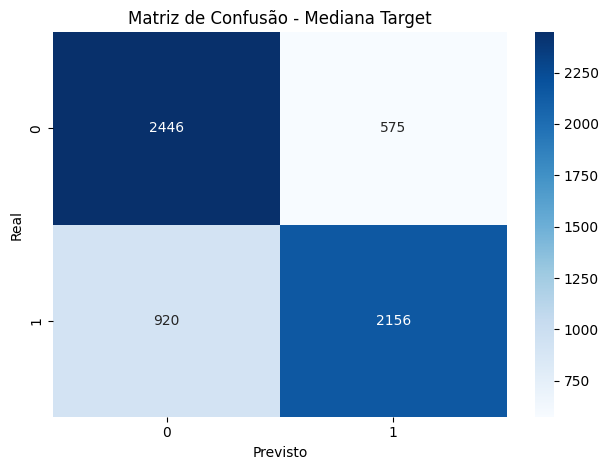


--- Top 15 Fatores Mais Importantes (mediana target) ---
                                              importance
Bene_Mdcd_Mdcr_Enrl_Stus_Medicare & Medicaid    0.061814
Bene_Age_Desc_All                               0.046465
Bene_Geo_Desc_Hawaii                            0.046018
Bene_Geo_Desc_California                        0.044281
Bene_Geo_Desc_Massachusetts                     0.044063
Bene_Geo_Desc_New York                          0.039276
Bene_Age_Desc_85 and over                       0.037777
Bene_Age_Desc_65-74                             0.037334
Bene_Geo_Desc_District Of Columbia              0.036279
Bene_Age_Desc_75-84                             0.033780
Bene_Geo_Desc_Maryland                          0.027851
Bene_RUCA_Desc_Rural                            0.025066
Bene_Geo_Desc_Rhode Island                      0.023498
Bene_Mdcd_Mdcr_Enrl_Stus_Medicare Only          0.021758
Bene_Geo_Desc_Minnesota                         0.019434


C:\Users\vinir\AppData\Local\Temp\ipykernel_16732\2484435391.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=top15, palette='viridis')


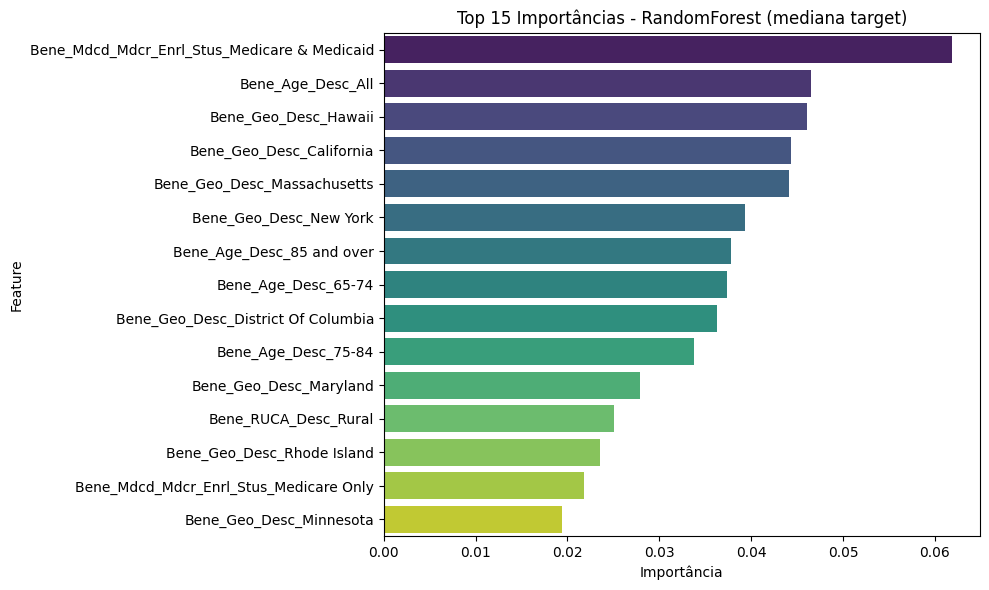

In [20]:
# Redefinir alvo com base na mediana global (Alta adoção = Pct_Telehealth > mediana)
median_val = df_clean['Pct_Telehealth'].median()
df_clean['High_Adoption'] = (df_clean['Pct_Telehealth'] > median_val).astype(int)

print(f"Mediana Pct_Telehealth: {median_val:.4f}")
print("Distribuição das classes (High_Adoption):")
print(df_clean['High_Adoption'].value_counts(normalize=True))

# Recriar X (one-hot) e y usando a nova definição de alvo
X = pd.get_dummies(df_clean[features_cat], drop_first=True)
y = df_clean['High_Adoption']

# Split treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Treinar Random Forest (substitui clf anterior)
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Avaliação
print("\n--- Relatório de Classificação ---")
print(classification_report(y_test, y_pred, digits=4))
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

print("\n--- Matriz de Confusão ---")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão - Mediana Target')
plt.ylabel('Real')
plt.xlabel('Previsto')
plt.tight_layout()
plt.show()

# Importâncias das features (top 15)
feature_importances = pd.DataFrame(clf.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
print("\n--- Top 15 Fatores Mais Importantes (mediana target) ---")
print(feature_importances.head(15))

plt.figure(figsize=(10, 6))
top15 = feature_importances.head(15).reset_index().rename(columns={'index':'feature'})
sns.barplot(x='importance', y='feature', data=top15, palette='viridis')
plt.title('Top 15 Importâncias - RandomForest (mediana target)')
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()